In [1]:
BUILD_DIR="build"
INPUT_FILE="sample.mp4"

IS_DEV_MODE=True
SAMPLER_FPS=0.25
SAMPLER_WIDTH=200
SAMPLER_HEIGHT=200

In [2]:
import cv2

from IPython.display import display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from deepface import DeepFace

In [4]:
def get_resized_image(np_img, width, height):
    resized_img = cv2.resize(np_img, (width, height), interpolation=cv2.INTER_LINEAR)
    return resized_img

In [5]:
def display_all_images(images, cols = 5):
    num_images = len(images)
    rows = int(np.ceil(num_images / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    cnt=0
    for ax, img in tqdm(zip(axes.flat, images), total=num_images, desc='Processing images to display'):
        display_image = np_array_to_image(img)
        ax.imshow(display_image)
        ax.axis('off')
        cnt = cnt + 1
    plt.tight_layout()
    plt.show()

In [6]:
from scenedetect import detect, ContentDetector
scene_list = detect(INPUT_FILE, ContentDetector())

In [7]:
from dataclasses import dataclass, field
import numpy as np

@dataclass
class AppFrame:
    frame: list
    detect: list = field(default=None)
    track: list = field(default=None)
    faces: list = field(default=None)
    _frame_gray: list = field(default=None)
    _frame_std_dev: int = field(default=None)
    
    @property
    def frame_gray(self):
        return self._frame_gray
        
    @property
    def frame_std_dev(self):
        return self._frame_std_dev
        
    def __post_init__(self):
        self._frame_gray = cv2.cvtColor(self.frame, cv2.COLOR_BGR2GRAY)
        self._frame_std_dev = np.std(self._frame_gray)

@dataclass
class AppScene:
    scene_orig: list = field(default=None)
    frame_start: int = field(default=None)
    frame_end: int = field(default=None)
    frames: list = field(default_factory=list)
    detects: list = field(default_factory=list)

In [8]:
def read_scene_frames(scene_list, max_num_of_frames_per_scene, frame_std_threshold=10):
    cap = cv2.VideoCapture(INPUT_FILE)
    app_scenes = []
    skipped_frames = []
    for scene in tqdm(scene_list, desc='Reading Frames from Scenes'):
        app_scene = AppScene()
        app_scene.scene_orig = scene
        scene_start_frame = scene[0].frame_num
        app_scene.frame_start = scene_start_frame
        scene_end_frame = scene[1].frame_num
        app_scene.frame_end = scene_end_frame
        incrementer = (scene_end_frame - scene_start_frame) / float(max_num_of_frames_per_scene)
        frame_idx = scene_start_frame + (incrementer / 2)
        while frame_idx < scene_end_frame:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            frame_idx = frame_idx + incrementer
            ret, frame = cap.read()
            app_frame = AppFrame(frame)
            if app_frame.frame_std_dev < frame_std_threshold:
                skipped_frames.append(app_frame)
                print('skipping frame')
                continue
            app_scene.frames.append(app_frame)
        app_scenes.append(app_scene)
    cap.release()
    return app_scenes, skipped_frames

app_scenes, skipped_frames = read_scene_frames(scene_list[:10], max_num_of_frames_per_scene=6, frame_std_threshold=10)

Reading Frames from Scenes:   0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
for i in tqdm(range(0, len(app_scenes)), desc='Detecting Objects from Frames'):
    scene = app_scenes[i]
    detects = model.track([ app_frame.frame for app_frame in scene.frames ], verbose=False)
    # tracks = model.track([ app_frame.frame for app_frame in scene.frames ])
    for i in range(len(detects)):
        app_frame = scene.frames[i]
        app_frame.detect = detects[i]


Detecting Objects from Frames:   0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
from libs import utils

Processing images to display:   0%|          | 0/30 [00:00<?, ?it/s]

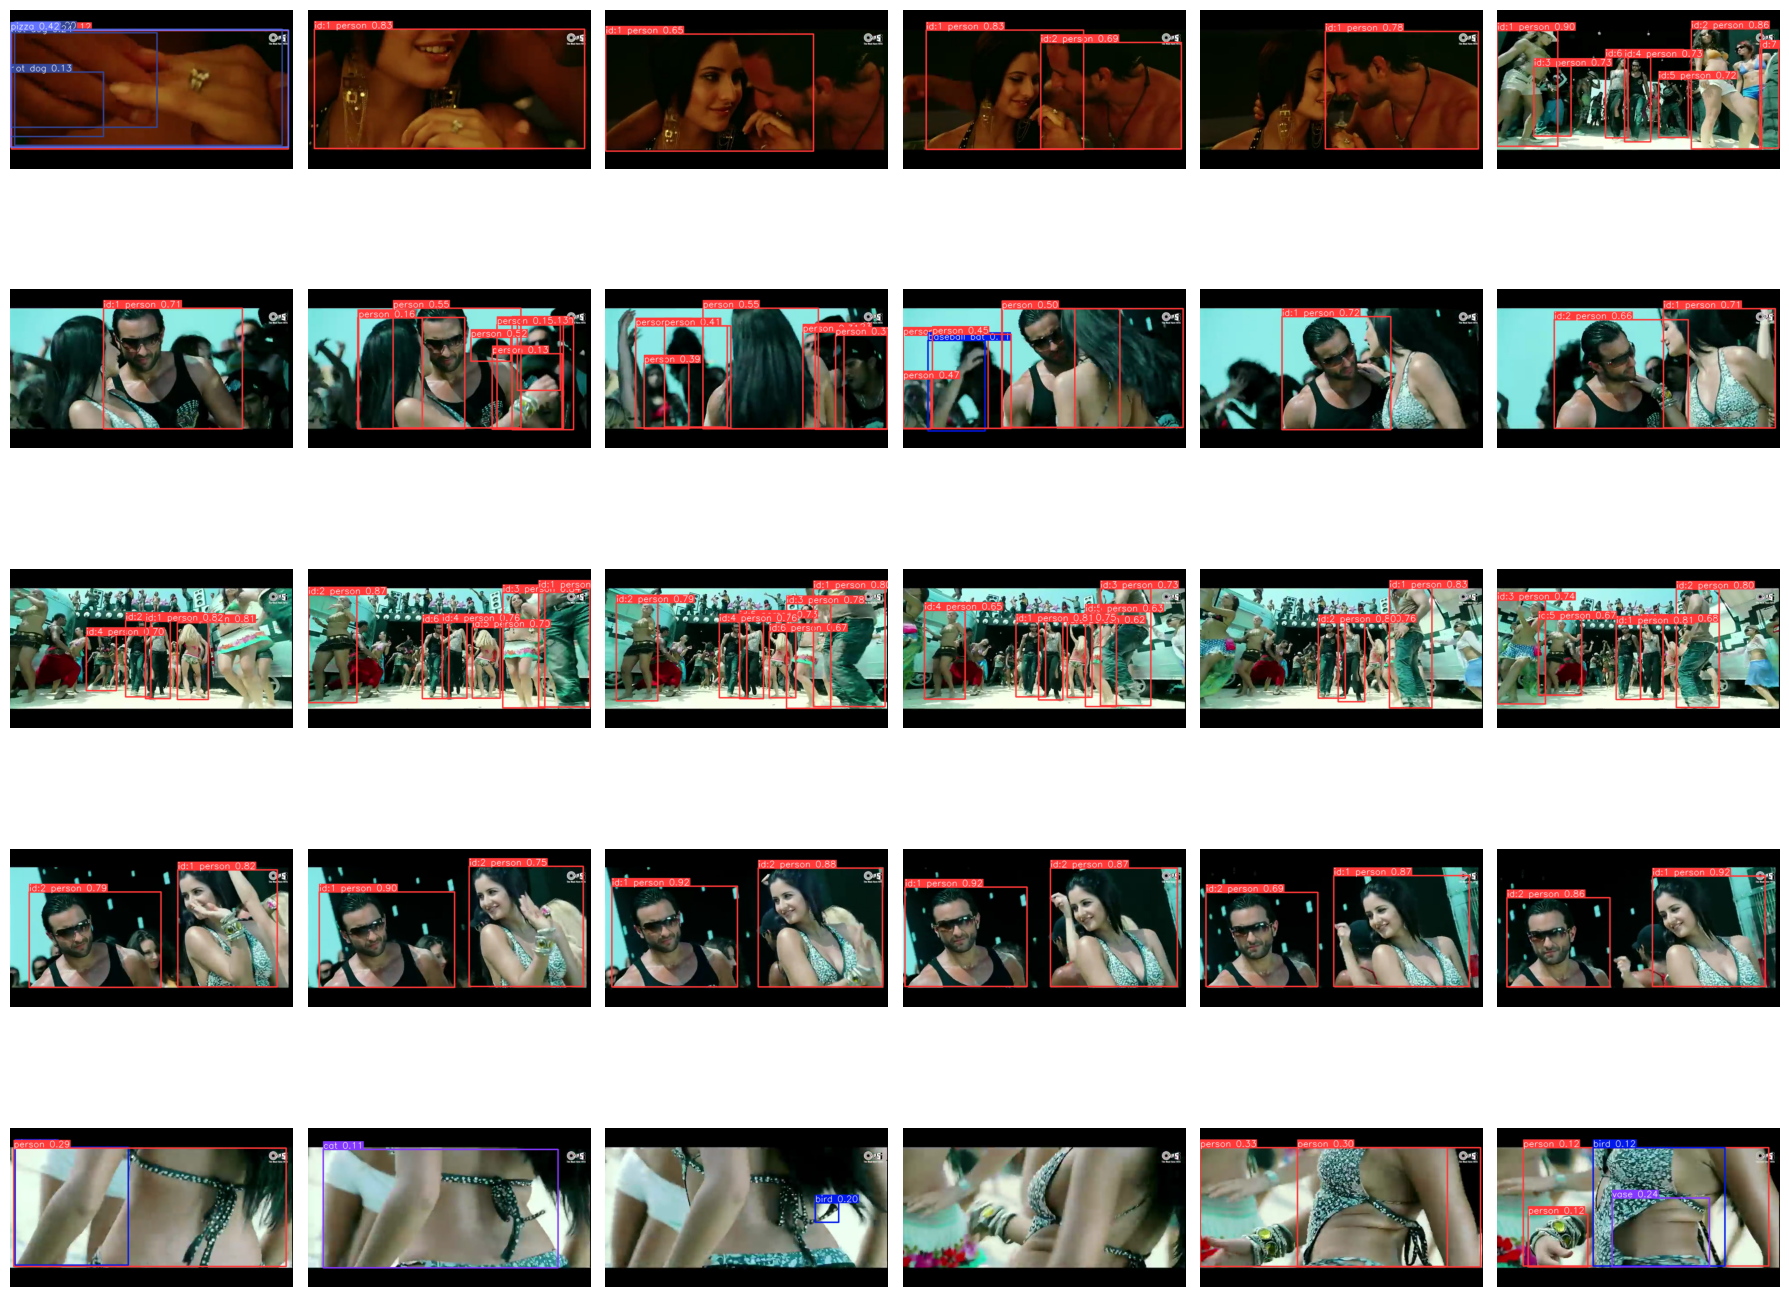

In [13]:
if IS_DEV_MODE:
    display_all_images(utils.flat_screen_frames(app_scenes[:5], lambda af:af.detect.plot()), 6)

In [16]:
yolo_person_class = utils.find_key(model.names, 'person')
for detect in utils.flat_screen_frames(app_scenes, lambda af:af.detect):
    detected_boxes = []
    for box in detect.boxes: 
        if int(box.cls[0]) == yolo_person_class:
            detected_boxes.append(box)
    detect.boxes = detected_boxes

Processing images to display:   0%|          | 0/5 [00:00<?, ?it/s]

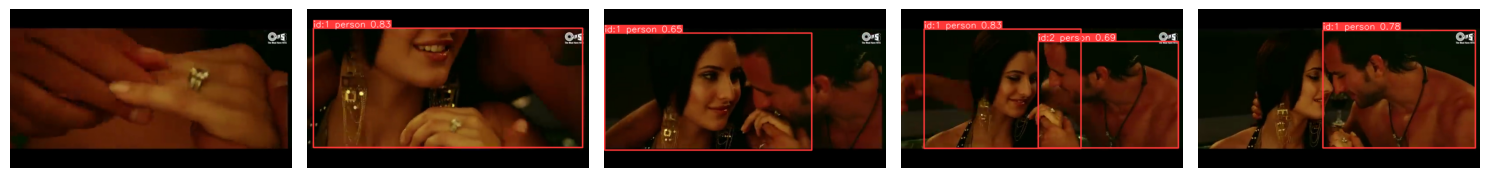

In [18]:
if IS_DEV_MODE:
    display_all_images(utils.flat_screen_frames(app_scenes, lambda af:af.detect.plot())[:5])

In [19]:
from abc import ABC, abstractmethod
from functools import wraps
import sys
import io

class AppFacer(ABC):

    @abstractmethod
    def init(this):
        pass
    
    @abstractmethod
    def detect_faces(this, image):
        pass

    @abstractmethod
    def get_boundary(this, face):
        pass

class OpenCVAppFacer(AppFacer):
    def init(this):
        this.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    def detect_faces(this, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = this.face_cascade.detectMultiScale(gray, 1.1, 4)
        return faces

    def get_boundary(this, face):
        return face


from mtcnn import MTCNN
class MTCNNAppFacer(AppFacer):
    def init(this):
        this.detector = MTCNN()
        this.detect_faces = capture_output(this.detect_faces)
    
    def detect_faces(this, image):
        faces = this.detector.detect_faces(image)
        return faces

    def get_boundary(this, face):
        return face['box']


class DeepFaceAppFacer(AppFacer):
    def init(this):
        pass
    
    def detect_faces(this, image):
        face_analysis = DeepFace.analyze(image, ['gender'], enforce_detection=False, silent=True)
        return face_analysis

    def get_boundary(this, face):
        region = face['region']
        return region['x'], region['y'], region['w'], region['h']

from types import SimpleNamespace
APP_FACERS = SimpleNamespace(
    opencv = OpenCVAppFacer(),
    mtcnn = MTCNNAppFacer(),
    deepface = DeepFaceAppFacer()
)

In [21]:
def detect_faces(app_scenes, app_facer):
    faces_width_threshold = 0.1
    app_facer.init()
    app_frames = utils.flat_screen_frames(app_scenes, lambda af:af)
    for app_frame in tqdm(app_frames, desc='Detecting Faces in Frames'):
        faces = app_facer.detect_faces(app_frame.frame)
        app_frame.faces = faces

app_facer = APP_FACERS.opencv
detect_faces(app_scenes, app_facer)

Detecting Faces in Frames:   0%|          | 0/60 [00:00<?, ?it/s]

Verifying Faces in Frames:   0%|          | 0/30 [00:00<?, ?it/s]

Processing images to display:   0%|          | 0/30 [00:00<?, ?it/s]

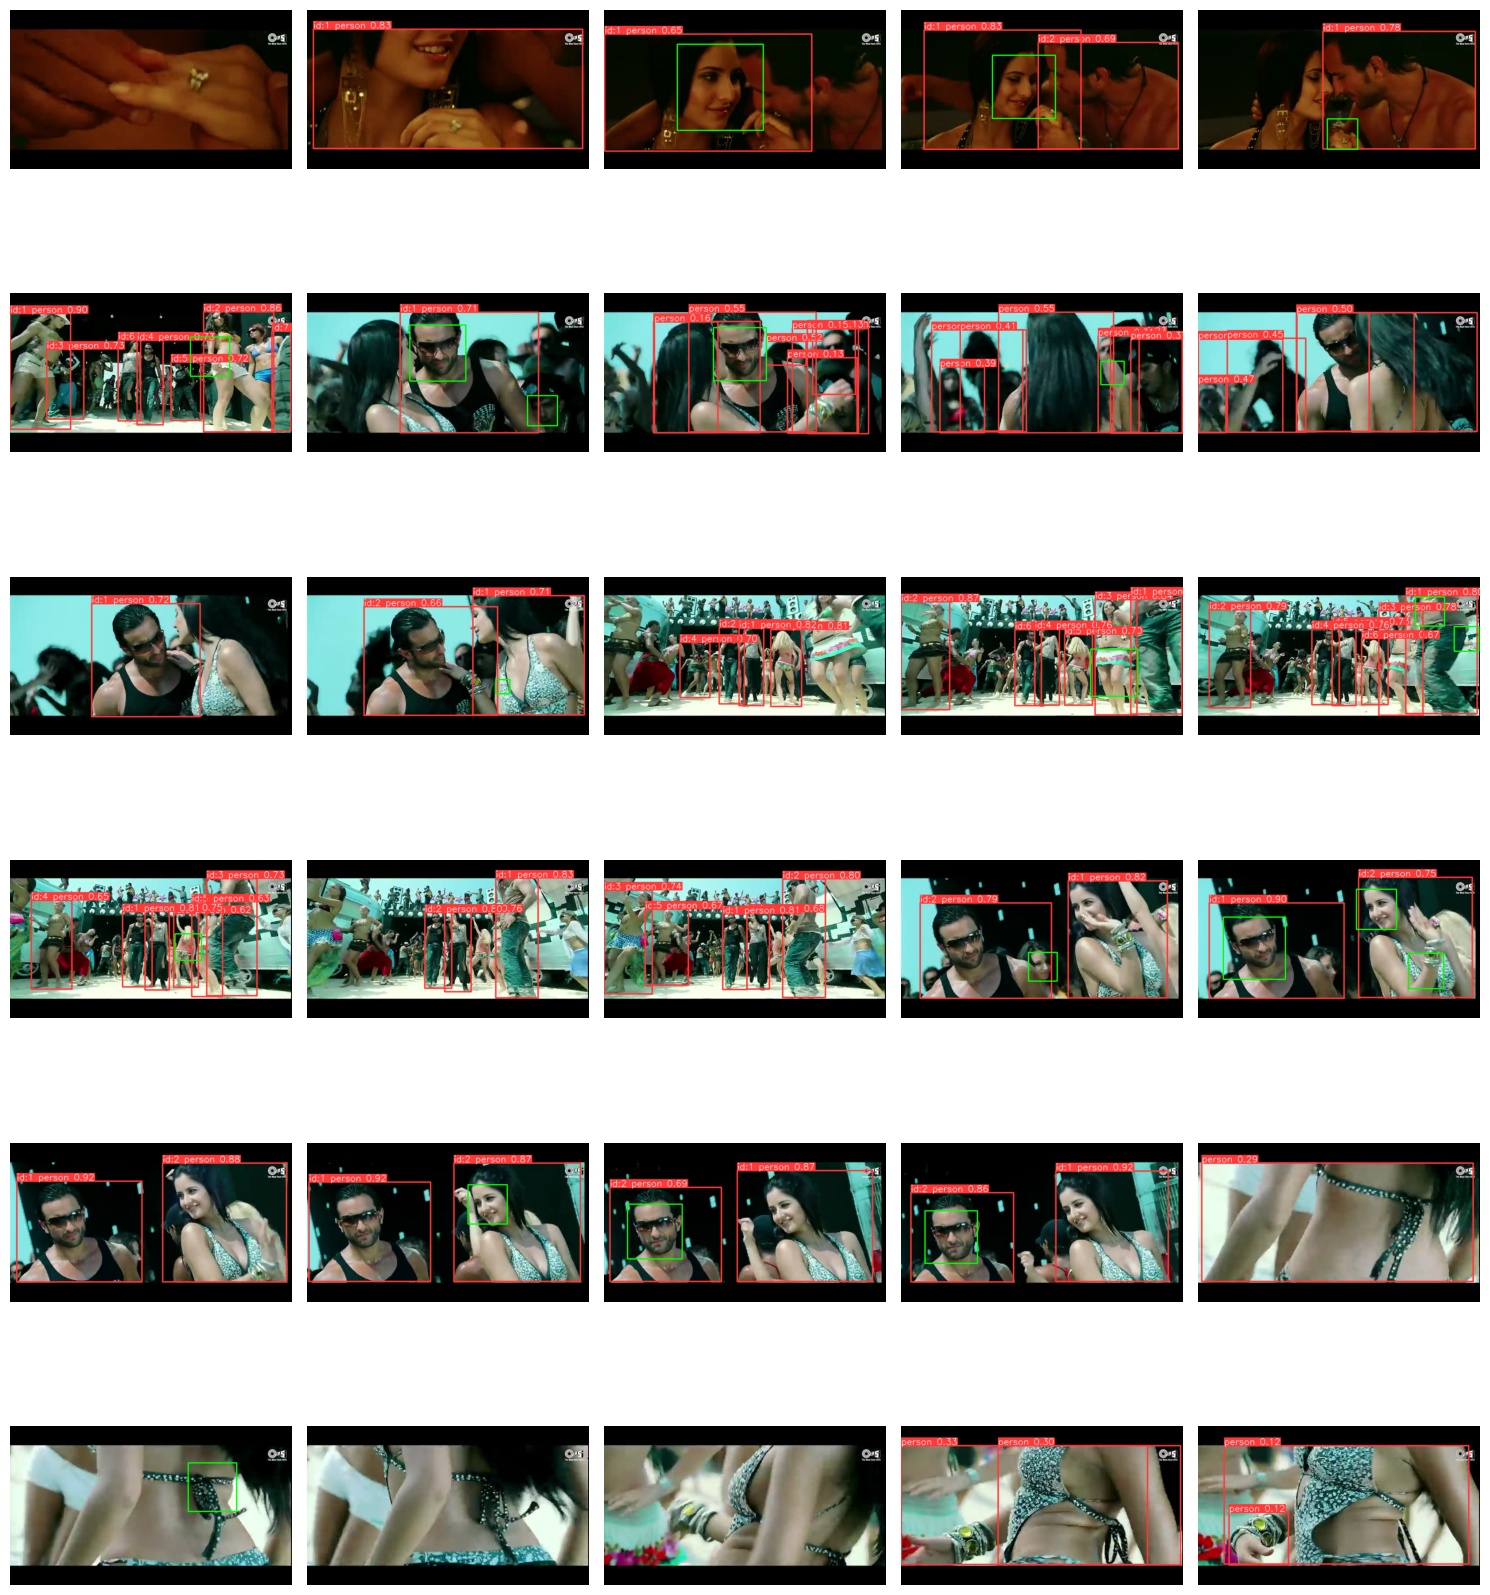

In [26]:
def show_faces(app_scenes):
    frame_faces = []
    for app_frame in tqdm(utils.flat_screen_frames(app_scenes[:5], lambda af:af), desc='Verifying Faces in Frames'):
        frame_copy = app_frame.detect.plot().copy()
        for face in app_frame.faces:
            x, y, w, h = app_facer.get_boundary(face)
            frame_copy = cv2.rectangle(frame_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
        frame_faces.append(frame_copy)
    display_all_images(frame_faces)
if IS_DEV_MODE:
    show_faces(app_scenes)

Cropping Faces from Frames:   0%|          | 0/60 [00:00<?, ?it/s]

Processing images to display:   0%|          | 0/10 [00:00<?, ?it/s]

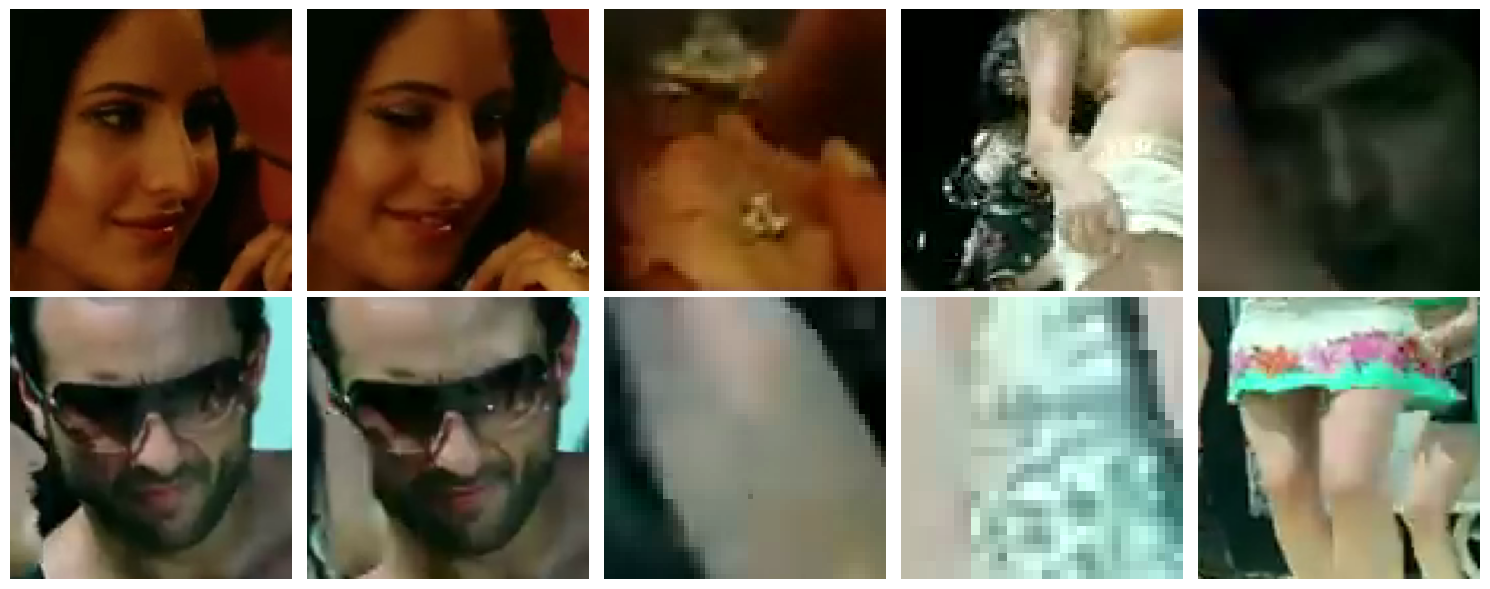

In [28]:
def get_cropped_faces(app_scenes):
    frame_faces = []
    for app_frame in tqdm(utils.flat_screen_frames(app_scenes, lambda af:af), desc='Cropping Faces from Frames'):
        frame = app_frame.frame
        for face in app_frame.faces:
            x, y, w, h = app_facer.get_boundary(face)
            frame_faces.append(frame[y:y+h, x:x+w])
    return frame_faces
frame_faces = get_cropped_faces(app_scenes)
if IS_DEV_MODE:
    display_all_images(frame_faces[:10])

In [30]:
def get_face_categories(frame_faces, frame_from=10):
    distance_threshold = 0.7
    face_categories = [[frame_faces[frame_from]]]
    for frame_face in tqdm(frame_faces[frame_from:frame_from+50], 'Recognizing Faces'):
        next_face_categories=face_categories.copy()
        is_found = False
        found_cat_arr = None
        for face_cats in face_categories:
            for face_cat in face_cats:
                verification = DeepFace.verify(frame_face, face_cat, enforce_detection=False)
                if verification['verified'] and verification['distance'] < distance_threshold:
                    is_found = True
                    found_cat_arr = face_cats
                    break
            if is_found: 
                break;    
        if is_found:
            found_cat_arr.append(frame_face)
        else:
            next_face_categories.append([frame_face])
        face_categories=next_face_categories
    return face_categories
face_categories = get_face_categories(frame_faces)

Recognizing Faces:   0%|          | 0/50 [00:00<?, ?it/s]

Processing images to display:   0%|          | 0/51 [00:00<?, ?it/s]

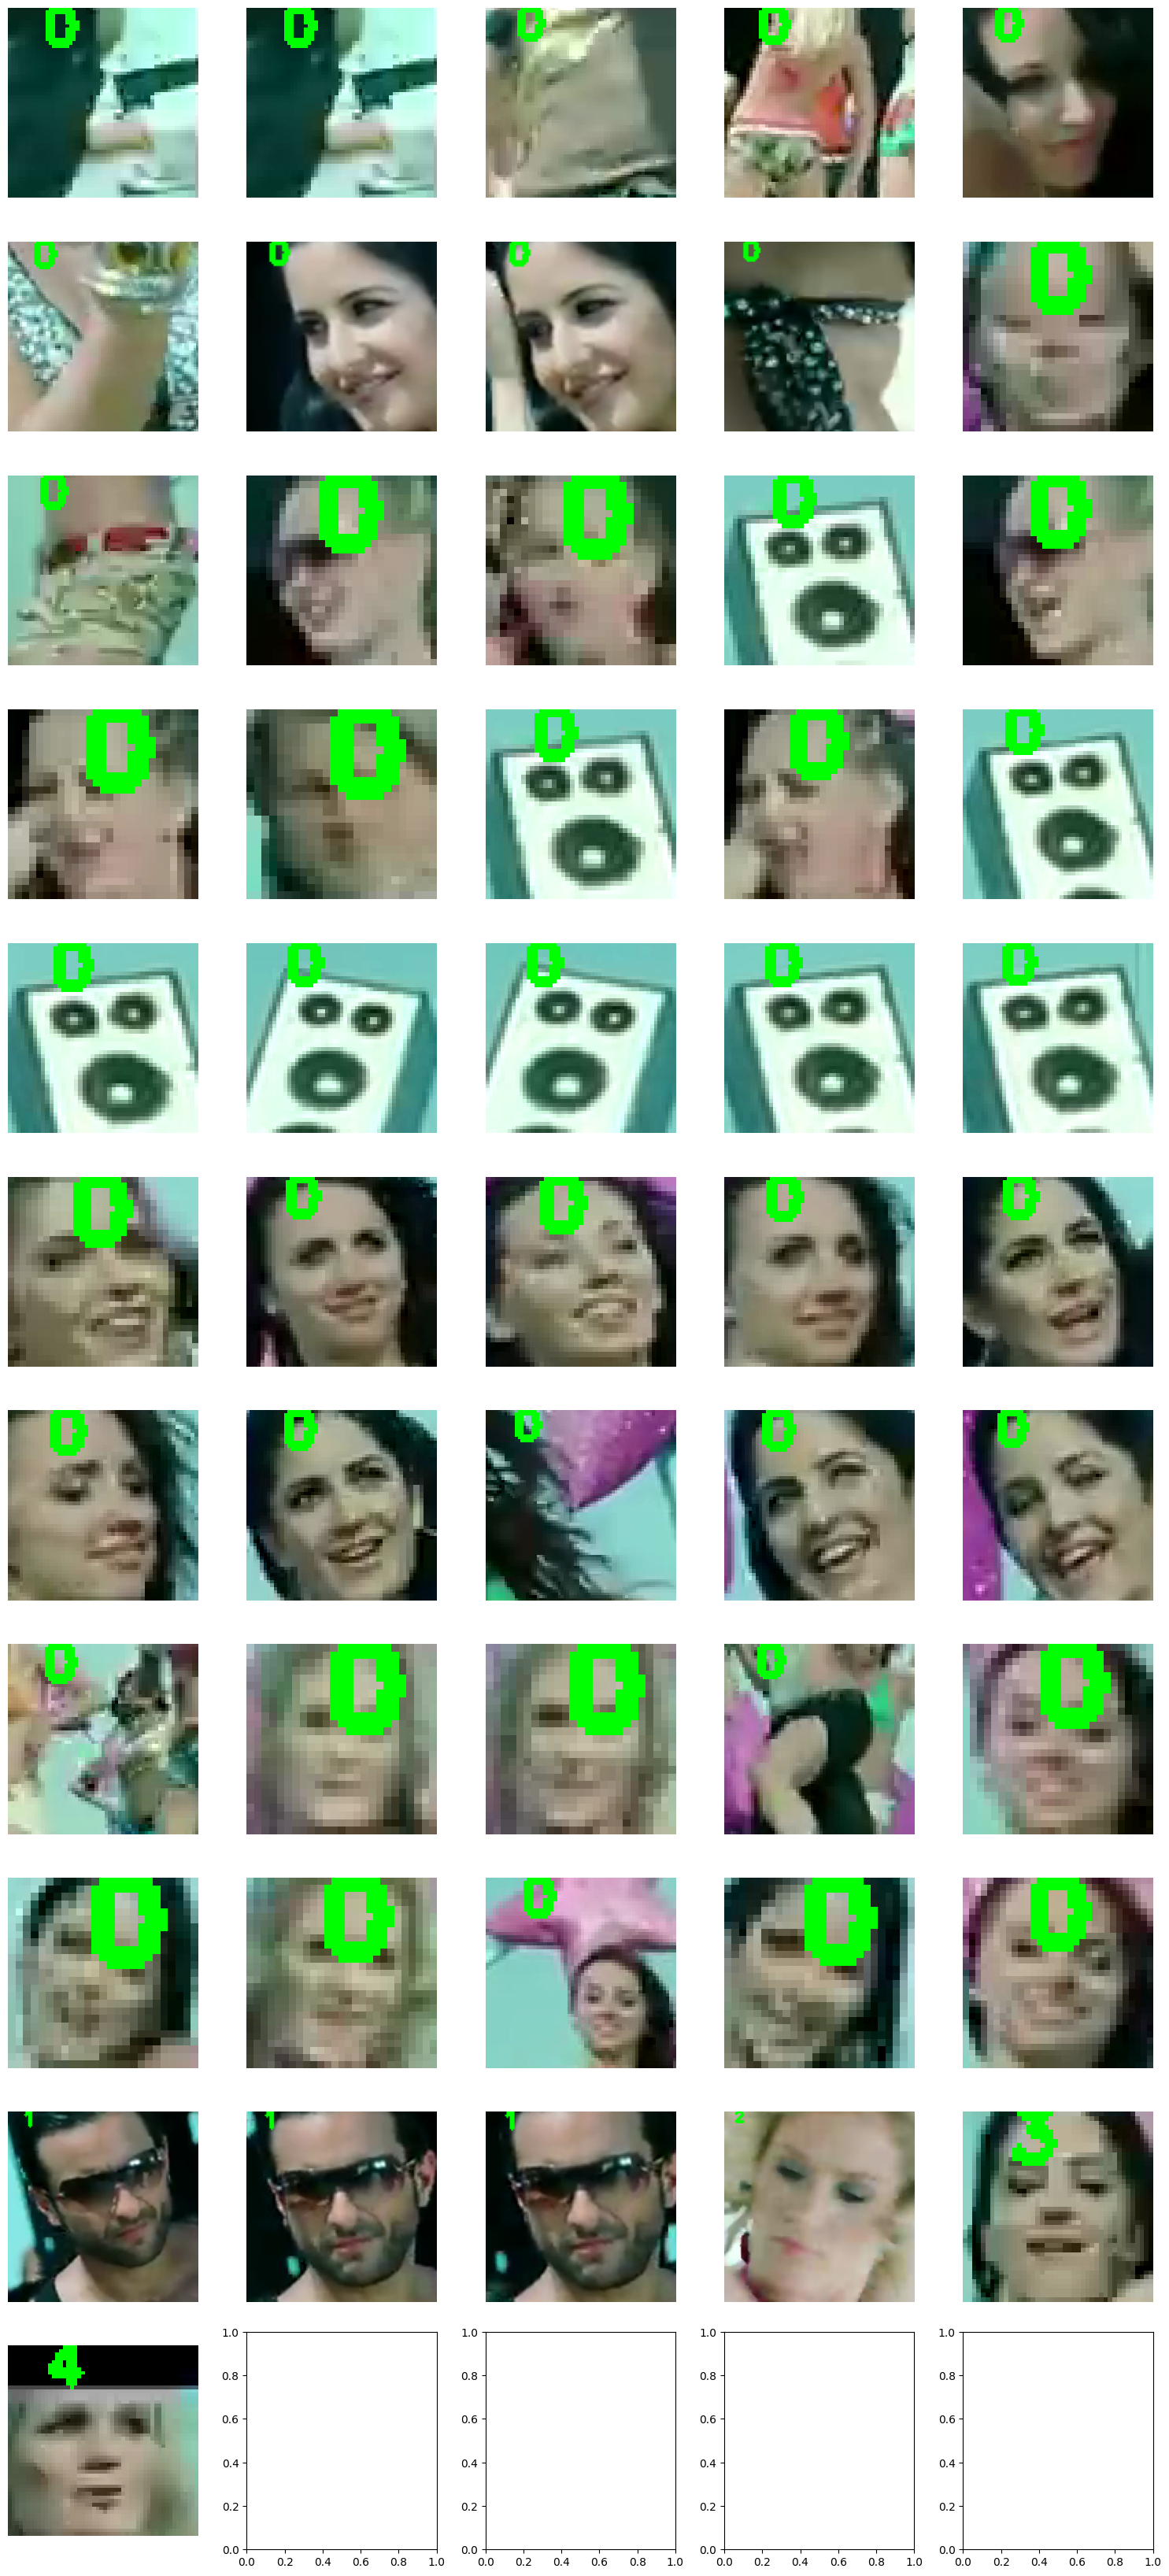

In [31]:
def get_face_display(face_categories):
    position = (10, 10)  # Bottom-left corner of the text in (x, y)
    font = cv2.FONT_HERSHEY_SIMPLEX  # Font type
    font_scale = 0.5  # Font scale (size)
    color = (0, 255, 0)  # Color in BGR (blue, green, red)
    thickness = 2  # Thickness of the lines used to draw the text
    face_display = []
    for face_category_index in range(0, len(face_categories)):
        face_category = face_categories[face_category_index]
        for face in face_category:
            face_copy = face.copy()
            cv2.putText(face_copy, str(face_category_index), position, font, font_scale, color, thickness)
            face_display.append(face_copy)
    return face_display
face_display = get_face_display(face_categories)
display_all_images(face_display)